# Smart Beta Strategy Optimized

This strategy tries to improve performance of my previous smart beta 5 factors models

The main ideas to improve the strategy comes from the book: Equity Smart Beta and Factor Investing For Practitioners


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Data Acquisition
# Load Russell 1000 ticker symbols
print("Step 1: Loading Russell 1000 ticker symbols")
russell1000 = pd.read_html('https://en.wikipedia.org/wiki/Russell_1000_Index')[2]
tickers = russell1000['Symbol'].to_list()
tickers = [ticker.replace('.', '-') for ticker in tickers]
print(f"Tickers loaded: {len(tickers)} symbols")

# Download historical price data
print("Step 1: Downloading historical price data...")
data = yf.download(tickers, start='2015-01-01', end='2023-10-01', progress=False)['Adj Close']
print(f"Data downloaded for {data.shape[1]} tickers with {data.shape[0]} rows of historical prices")

Step 1: Loading Russell 1000 ticker symbols
Tickers loaded: 1009 symbols
Step 1: Downloading historical price data...



11 Failed downloads:
['SOLV', 'GEV', 'AS', 'VSTS', 'SW', 'SEG', 'VLTO', 'BIRK', 'ALAB', 'GRAL', 'LOAR']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-01-01 -> 2023-10-01) (Yahoo error = "Data doesn\'t exist for startDate = 1420088400, endDate = 1696132800")')


Data downloaded for 1009 tickers with 2201 rows of historical prices


In [2]:
# Step 2: Data Cleaning
print("Step 2: Cleaning data...")
data = data.ffill().dropna(axis=1)
print(f"Data after cleaning: {data.shape[1]} tickers")

Step 2: Cleaning data...
Data after cleaning: 812 tickers


In [3]:
# Step 3: Calculating Factor Signals
print("Step 3: Calculating daily and monthly returns...")
daily_returns = data.pct_change()
monthly_prices = data.resample('ME').last()
monthly_returns = monthly_prices.pct_change()

# Calculate factors (Value, Size, Low Volatility, Profitability, Momentum)
print("Step 3: Calculating value factor (Inverse P/B ratio)...")
pb_ratios = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        pb = stock.info['priceToBook']
        pb_ratios[ticker] = pb
        print(f"Ticker {ticker}: P/B = {pb}")
    except Exception as e:
        pb_ratios[ticker] = np.nan
        print(f"Failed to retrieve P/B ratio for {ticker}: {e}")

pb_series = pd.Series(pb_ratios)
value_signal = 1 / pb_series

print("Step 3: Calculating size factor (Inverse Market Cap)...")
market_caps = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        mc = stock.info['marketCap']
        market_caps[ticker] = mc
        print(f"Ticker {ticker}: Market Cap = {mc}")
    except Exception as e:
        market_caps[ticker] = np.nan
        print(f"Failed to retrieve market cap for {ticker}: {e}")

market_caps_series = pd.Series(market_caps)
size_signal = 1 / market_caps_series

print("Step 3: Calculating low volatility factor (Inverse Volatility)...")
volatility_signal = daily_returns.rolling(window=252).std() * np.sqrt(252)
latest_volatility = volatility_signal.iloc[-1]
low_volatility_signal = 1 / latest_volatility
print("Low volatility signal calculated")

print("Step 3: Calculating profitability factor (ROE)...")
roe_ratios = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        roe = stock.info['returnOnEquity']
        roe_ratios[ticker] = roe
        print(f"Ticker {ticker}: ROE = {roe}")
    except Exception as e:
        roe_ratios[ticker] = np.nan
        print(f"Failed to retrieve ROE for {ticker}: {e}")

profitability_signal = pd.Series(roe_ratios)

print("Step 3: Calculating momentum factor...")
momentum_signal = monthly_returns.shift(1).rolling(window=11).apply(lambda x: np.prod(1 + x) - 1)
momentum_signal_latest = momentum_signal.iloc[-1]
print("Momentum signal calculated")

# Combine signals into DataFrame
print("Step 3: Combining factor signals into a DataFrame...")
signals = pd.DataFrame({
    'Value': value_signal,
    'Size': size_signal,
    'Low_Volatility': low_volatility_signal,
    'Profitability': profitability_signal,
    'Momentum': momentum_signal_latest
})

# Data Cleaning
print("Step 3: Cleaning signals DataFrame...")
signals = signals.dropna()
print(f"Signals after cleaning: {signals.shape[0]} stocks with {signals.shape[1]} factors")

# Normalize signals
def normalize_series(series):
    return (series - series.mean()) / series.std()

print("Step 3: Normalizing signals...")
normalized_signals = signals.apply(normalize_series)
print("Signals normalized")

Step 3: Calculating daily and monthly returns...
Step 3: Calculating value factor (Inverse P/B ratio)...
Ticker TXG: P/B = 3.7570715
Ticker MMM: P/B = 19.17789
Ticker AOS: P/B = 6.8535895
Ticker AAON: P/B = 11.788369
Ticker ABT: P/B = 5.045137
Ticker ABBV: P/B = 51.45388
Ticker ACHC: P/B = 1.9688267
Ticker ACN: P/B = 7.822085
Ticker AYI: P/B = 3.713057
Ticker ADBE: P/B = 15.841517
Ticker ADT: P/B = 1.7136763
Ticker AAP: P/B = 0.8866805
Ticker WMS: P/B = 8.858577
Ticker AMD: P/B = 4.6956472
Ticker ACM: P/B = 6.0976615
Ticker AES: P/B = 4.6136155
Ticker AMG: P/B = 1.7721872
Ticker AFRM: P/B = 4.6476145
Ticker AFL: P/B = 2.409535
Ticker AGCO: P/B = 1.8017123
Ticker A: P/B = 7.2323422
Ticker ADC: P/B = 1.5164571
Ticker AGNC: P/B = 1.1417967
Ticker AL: P/B = 0.6903227
Ticker APD: P/B = 4.38317
Ticker ABNB: P/B = 10.04754
Ticker AKAM: P/B = 3.2253425
Ticker ALK: P/B = 1.3530256
Ticker ALB: P/B = 1.2385087
Ticker ACI: P/B = 3.673956
Ticker AA: P/B = 2.5561519
Ticker ARE: P/B = 1.1187632
Ticke

In [4]:
# Step 4: Factor Weighting Optimization
# Prepare signals and returns
print("Step 4: Preparing signals and returns for optimization...")
common_tickers = list(set(normalized_signals.index) & set(daily_returns.columns))
signals = normalized_signals.loc[common_tickers]
returns = daily_returns[common_tickers]
print(f"Common tickers: {len(common_tickers)}")

# Optimize factor weights
def optimize_factor_weights(signals, returns):
    initial_weights = np.array([0.2] * len(signals.columns))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(signals.columns)))

    def negative_sharpe(weights):
        combined_signal = signals.dot(weights)
        ranked_stocks = combined_signal.sort_values(ascending=False)
        top_n = ranked_stocks.head(50)
        portfolio_weights = top_n / top_n.abs().sum()
        portfolio_returns = returns[top_n.index].mul(portfolio_weights, axis=1).sum(axis=1)
        annual_return = portfolio_returns.mean() * 252
        annual_volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_volatility
        print(f"Evaluating weights: {weights}, Sharpe Ratio: {sharpe_ratio}")
        return -sharpe_ratio

    result = minimize(negative_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    return optimal_weights

print("Step 4: Optimizing factor weights...")
optimal_factor_weights = optimize_factor_weights(signals, returns)
print("Optimal Factor Weights:")
for factor, weight in zip(signals.columns, optimal_factor_weights):
    print(f"{factor}: {weight:.2%}")

# Update combined signal with optimal weights
combined_signal = signals.dot(optimal_factor_weights)

Step 4: Preparing signals and returns for optimization...
Common tickers: 770
Step 4: Optimizing factor weights...
Evaluating weights: [0.2 0.2 0.2 0.2 0.2], Sharpe Ratio: 0.8281554700780184
Evaluating weights: [0.20000001 0.2        0.2        0.2        0.2       ], Sharpe Ratio: 0.8281554690775287
Evaluating weights: [0.2        0.20000001 0.2        0.2        0.2       ], Sharpe Ratio: 0.8281554594996723
Evaluating weights: [0.2        0.2        0.20000001 0.2        0.2       ], Sharpe Ratio: 0.828155468348062
Evaluating weights: [0.2        0.2        0.2        0.20000001 0.2       ], Sharpe Ratio: 0.8281554741270528
Evaluating weights: [0.2        0.2        0.2        0.2        0.20000001], Sharpe Ratio: 0.8281554793377754
Evaluating weights: [0.00000000e+00 1.94289029e-16 0.00000000e+00 3.25157162e-01
 6.74842838e-01], Sharpe Ratio: 1.1147352946543132
Evaluating weights: [1.49011612e-08 1.94289029e-16 0.00000000e+00 3.25157162e-01
 6.74842838e-01], Sharpe Ratio: 1.11473529

In [5]:
# Step 5: Portfolio Construction
print("Step 5: Constructing portfolio...")
ranked_stocks = combined_signal.sort_values(ascending=False)
top_n = ranked_stocks.head(50)
portfolio_weights = top_n / top_n.abs().sum()
print("Portfolio constructed")

Step 5: Constructing portfolio...
Portfolio constructed


In [6]:
# Step 6: Backtesting (with shift to avoid lookahead bias)
print("Step 6: Backtesting portfolio with shift to avoid lookahead bias...")
rebalance_dates = monthly_prices.index[12::3]  # Quarterly rebalancing
portfolio_returns = pd.Series(dtype=float)

for i in range(len(rebalance_dates)-1):
    start_date = rebalance_dates[i]
    end_date = rebalance_dates[i+1]
    print(f"Backtesting from {start_date} to {end_date}...")

    # Adjust weights based on the previous period's signal (avoiding lookahead bias)
    period_prices = data.loc[start_date:end_date, portfolio_weights.index]
    period_returns = period_prices.pct_change().dropna()

    # Shift the returns to avoid lookahead bias
    shifted_returns = period_returns.shift(-1).dropna()

    # Apply portfolio weights from the beginning of the period to the returns of the period
    returns = shifted_returns.mul(portfolio_weights, axis=1).sum(axis=1)

    if portfolio_returns.empty:
        portfolio_returns = returns
    else:
        portfolio_returns = pd.concat([portfolio_returns, returns])


Step 6: Backtesting portfolio with shift to avoid lookahead bias...
Backtesting from 2016-01-31 00:00:00+00:00 to 2016-04-30 00:00:00+00:00...
Backtesting from 2016-04-30 00:00:00+00:00 to 2016-07-31 00:00:00+00:00...
Backtesting from 2016-07-31 00:00:00+00:00 to 2016-10-31 00:00:00+00:00...
Backtesting from 2016-10-31 00:00:00+00:00 to 2017-01-31 00:00:00+00:00...
Backtesting from 2017-01-31 00:00:00+00:00 to 2017-04-30 00:00:00+00:00...
Backtesting from 2017-04-30 00:00:00+00:00 to 2017-07-31 00:00:00+00:00...
Backtesting from 2017-07-31 00:00:00+00:00 to 2017-10-31 00:00:00+00:00...
Backtesting from 2017-10-31 00:00:00+00:00 to 2018-01-31 00:00:00+00:00...
Backtesting from 2018-01-31 00:00:00+00:00 to 2018-04-30 00:00:00+00:00...
Backtesting from 2018-04-30 00:00:00+00:00 to 2018-07-31 00:00:00+00:00...
Backtesting from 2018-07-31 00:00:00+00:00 to 2018-10-31 00:00:00+00:00...
Backtesting from 2018-10-31 00:00:00+00:00 to 2019-01-31 00:00:00+00:00...
Backtesting from 2019-01-31 00:0

Step 7: Plotting portfolio vs benchmark...


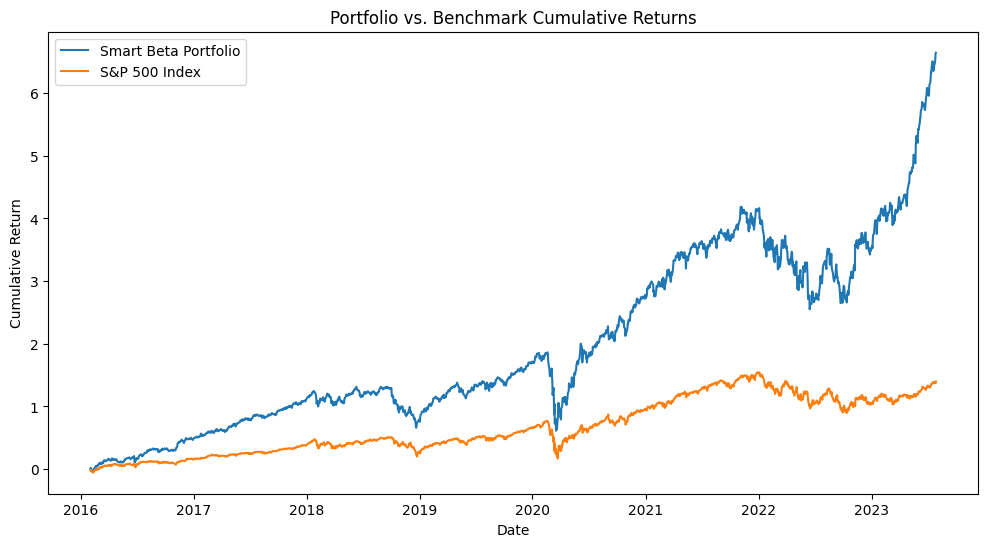

In [7]:
# Step 7: Plot Portfolio vs. Benchmark
portfolio_returns = portfolio_returns.tz_localize(None)
print("Step 7: Plotting portfolio vs benchmark...")
benchmark_data = yf.download('^GSPC', start='2015-01-01', end='2023-10-01', progress=False)['Adj Close']
benchmark_data = benchmark_data.tz_localize(None)
benchmark_returns = benchmark_data.pct_change().loc[portfolio_returns.index]

# Calculate cumulative returns
portfolio_cumulative_returns = (1 + portfolio_returns).cumprod() - 1
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1

# Plotting
plt.figure(figsize=(12,6))
plt.plot(portfolio_cumulative_returns, label='Smart Beta Portfolio')
plt.plot(benchmark_cumulative_returns, label='S&P 500 Index')
plt.title('Portfolio vs. Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [8]:
def calculate_performance_metrics(returns):
    # Annualized return
    cumulative_return = (1 + returns).prod() - 1
    num_years = (returns.index[-1] - returns.index[0]).days / 365.25
    annual_return = (1 + cumulative_return) ** (1 / num_years) - 1
    # Annualized volatility
    annual_volatility = returns.std() * np.sqrt(252)
    # Sharpe Ratio (Assuming risk-free rate is zero)
    sharpe_ratio = annual_return / annual_volatility
    return annual_return, annual_volatility, sharpe_ratio

In [9]:
annual_return, annual_volatility, sharpe_ratio = calculate_performance_metrics(benchmark_returns)

print(f'Benchmark Annual Return: {annual_return:.2%}')
print(f'Benchmark Annual Volatility: {annual_volatility:.2%}')
print(f'Benchmark Sharpe Ratio: {sharpe_ratio:.2f}')

Benchmark Annual Return: 12.40%
Benchmark Annual Volatility: 18.93%
Benchmark Sharpe Ratio: 0.65


In [10]:
annual_return_pf, annual_volatility_pf, sharpe_ratio_pf = calculate_performance_metrics(portfolio_returns)

print(f'Portfolio Annual Return: {annual_return_pf:.2%}')
print(f'Portfolio Annual Volatility: {annual_volatility_pf:.2%}')
print(f'Portfolio Sharpe Ratio: {sharpe_ratio_pf:.2f}')

Portfolio Annual Return: 31.23%
Portfolio Annual Volatility: 25.58%
Portfolio Sharpe Ratio: 1.22


Step 8: Performing forward test with extended data...
Cleaning extended data...
Calculating extended factor signals...
Extended: Value factor remains unchanged
Extended: Size factor remains unchanged
Calculating extended low volatility factor...
Extended: Profitability factor remains unchanged
Calculating extended momentum factor...
Combining extended factor signals into a DataFrame...
Cleaning extended signals DataFrame...
Extended signals after cleaning: 930 stocks with 5 factors
Normalizing extended signals...
Extended signals normalized
Filtering extended signals for the forward test period (after 2023-10-01)...
Applying optimal factor weights to forward signals...
Constructing forward portfolio...
Forward portfolio constructed
Running forward test...
Calculating cumulative returns for the forward period...
Plotting forward test results...


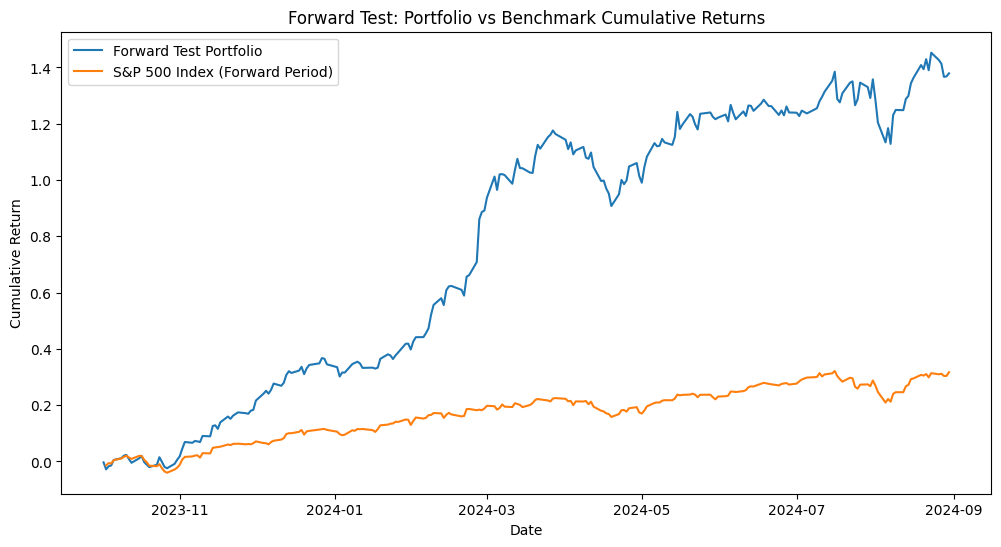

In [11]:
# Step 8: Forward Testing with data from 2022-01-01
print("Step 8: Performing forward test with extended data...")

# Download historical price data from 2022-01-01 to calculate factors
extended_start_date = '2022-01-01'
extended_end_time = '2024-08-31'
print(f"Downloading extended data from {extended_start_date} to {extended_end_time}...")
extended_data = yf.download(tickers, start=extended_start_date, end=extended_end_time, progress=False)['Adj Close']
extended_data = extended_data.tz_localize(None)
print("Cleaning extended data...")
extended_data = extended_data.ffill().dropna(axis=1)

# Calculate factor signals for the forward test period using extended data
print("Calculating extended factor signals...")
extended_daily_returns = extended_data.pct_change()
extended_monthly_prices = extended_data.resample('ME').last()
extended_monthly_returns = extended_monthly_prices.pct_change()

# Calculate factors using extended data up to 2023-10-01
# Value factor (Inverse P/B ratio) remains the same
print("Extended: Value factor remains unchanged")

# Size factor (Inverse Market Cap) remains the same
print("Extended: Size factor remains unchanged")

# Low Volatility Factor
print("Calculating extended low volatility factor...")
extended_volatility_signal = extended_daily_returns.rolling(window=252).std() * np.sqrt(252)
latest_extended_volatility = extended_volatility_signal.iloc[-1]
extended_low_volatility_signal = 1 / latest_extended_volatility

# Profitability factor (ROE) remains the same
print("Extended: Profitability factor remains unchanged")

# Momentum factor
print("Calculating extended momentum factor...")
extended_momentum_signal = extended_monthly_returns.shift(1).rolling(window=11).apply(lambda x: np.prod(1 + x) - 1)
extended_momentum_signal_latest = extended_momentum_signal.iloc[-1]

# Combine extended signals into a DataFrame
print("Combining extended factor signals into a DataFrame...")
extended_signals = pd.DataFrame({
    'Value': value_signal,
    'Size': size_signal,
    'Low_Volatility': extended_low_volatility_signal,
    'Profitability': profitability_signal,
    'Momentum': extended_momentum_signal_latest
})

# Data Cleaning for extended signals
print("Cleaning extended signals DataFrame...")
extended_signals = extended_signals.dropna()
print(f"Extended signals after cleaning: {extended_signals.shape[0]} stocks with {extended_signals.shape[1]} factors")

# Normalize extended signals
print("Normalizing extended signals...")
extended_normalized_signals = extended_signals.apply(normalize_series)
print("Extended signals normalized")

# Filter extended signals for data after 2023-10-01
print("Filtering extended signals for the forward test period (after 2023-10-01)...")
forward_test_start_date = '2023-10-01'
forward_daily_returns = extended_daily_returns.loc[forward_test_start_date:]
forward_signals = extended_normalized_signals

# Apply optimal factor weights to forward signals
print("Applying optimal factor weights to forward signals...")
forward_combined_signal = forward_signals.dot(optimal_factor_weights)

# Construct forward portfolio
print("Constructing forward portfolio...")
forward_ranked_stocks = forward_combined_signal.sort_values(ascending=False)
forward_top_n = forward_ranked_stocks.head(50)
forward_portfolio_weights = forward_top_n / forward_top_n.abs().sum()
print("Forward portfolio constructed")

# Forward testing on daily returns starting from 2023-10-01
print("Running forward test...")
forward_returns = forward_daily_returns[forward_portfolio_weights.index].dropna()
forward_portfolio_returns = forward_returns.mul(forward_portfolio_weights, axis=1).sum(axis=1)

# Calculate cumulative returns for the forward period
print("Calculating cumulative returns for the forward period...")
forward_portfolio_cumulative_returns = (1 + forward_portfolio_returns).cumprod() - 1

# Download S&P 500 data for forward test period
print("Downloading S&P 500 benchmark data for the forward period...")
forward_benchmark_data = yf.download('^GSPC', start=forward_test_start_date, end=extended_end_time, progress=False)['Adj Close']
forward_benchmark_data = forward_benchmark_data.tz_localize(None)
forward_benchmark_returns = forward_benchmark_data.pct_change().loc[forward_portfolio_returns.index]
forward_benchmark_cumulative_returns = (1 + forward_benchmark_returns).cumprod() - 1

# Plotting forward test results
print("Plotting forward test results...")
plt.figure(figsize=(12,6))
plt.plot(forward_portfolio_cumulative_returns, label='Forward Test Portfolio')
plt.plot(forward_benchmark_cumulative_returns, label='S&P 500 Index (Forward Period)')
plt.title('Forward Test: Portfolio vs Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


In [12]:
forward_annual_return, forward_annual_volatility, forward_sharpe_ratio = calculate_performance_metrics(forward_benchmark_returns)

print(f'Forward Benchmark Annual Return: {forward_annual_return:.2%}')
print(f'Forward Benchmark Annual Volatility: {forward_annual_volatility:.2%}')
print(f'Forward Benchmark Sharpe Ratio: {forward_sharpe_ratio:.2f}')

Forward Benchmark Annual Return: 35.27%
Forward Benchmark Annual Volatility: 12.48%
Forward Benchmark Sharpe Ratio: 2.83


In [13]:
forward_annual_return_pf, forward_annual_volatility_pf, forward_sharpe_ratio_pf = calculate_performance_metrics(forward_portfolio_returns)

print(f'Forward Portfolio Annual Return: {forward_annual_return_pf:.2%}')
print(f'Forward Portfolio Annual Volatility: {forward_annual_volatility_pf:.2%}')
print(f'Forward Portfolio Sharpe Ratio: {forward_sharpe_ratio_pf:.2f}')

Forward Portfolio Annual Return: 158.74%
Forward Portfolio Annual Volatility: 26.46%
Forward Portfolio Sharpe Ratio: 6.00


In [14]:
import quantstats as qs

# Set up QuantStats
qs.extend_pandas()

# Assuming `forward_portfolio_returns` is your returns time series
# Calculate forward portfolio cumulative returns for the QuantStats analysis
forward_portfolio_cumulative_returns = (1 + forward_portfolio_returns).cumprod() - 1


# If you want to save the report as an HTML file
qs.reports.html(forward_portfolio_returns, benchmark='^GSPC', output='../reports/03 - smart_beta_strategy_optimized.html')



[*********************100%***********************]  1 of 1 completed
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\sandr\Documents\GitHub\portfolio_strategies_management\venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with a

In [15]:
def get_latest_portfolio_stocks(ranked_stocks, n=50):
    """
    Function to get the stock names for the last available date in the portfolio.

    Parameters:
    - ranked_stocks (pd.Series): Series with stocks ranked by combined signal.
    - n (int): Number of top stocks to return, default is 50.

    Returns:
    - pd.Index: List of top 'n' stock names.
    """
    # Get the top 'n' stocks by the latest combined signal
    top_stocks = ranked_stocks.head(n).index
    return top_stocks

# Example usage:
top_stocks = get_latest_portfolio_stocks(ranked_stocks)
print(f"Top stocks for the last available date: {top_stocks}")


Top stocks for the last available date: Index(['SMCI', 'NVDA', 'HRB', 'CL', 'XPO', 'RCL', 'HD', 'EXAS', 'BLDR', 'FTNT',
       'ORCL', 'GE', 'TPX', 'LII', 'SAIA', 'FTI', 'CCL', 'PHM', 'META', 'CELH',
       'SPB', 'JBL', 'AVGO', 'ADBE', 'VRSK', 'SSD', 'LRCX', 'LSCC', 'EME',
       'TOL', 'CXT', 'HUBS', 'APO', 'AMAT', 'MSI', 'MA', 'FIX', 'SCCO', 'ALSN',
       'KLAC', 'NFLX', 'CAT', 'OC', 'PVH', 'LLY', 'AXON', 'EXP', 'LNW', 'URI',
       'KMB'],
      dtype='object')
